In [1]:
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
import os, datetime, glob
from shutil import copyfile
from sklearn.metrics import confusion_matrix
import itertools

reSize = (224, 224)
batchSize = 32
h5FileName = "ResNet50-V2-simpons.h5"

In [2]:
def create_model():
    ResNet = keras.applications.ResNet50V2(
        include_top=False, weights="imagenet", input_shape=(reSize[0], reSize[1], 3)
    )
    return models.Sequential(
        [
            ResNet,
            layers.GlobalAveragePooling2D(),
            layers.Dense(512, activation="relu"),
            layers.Dense(20, activation="softmax"),
        ]
    )

In [3]:
train = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
)
valid = keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

trainGenerator = train.flow_from_directory(
    "train",
    target_size=reSize,
    batch_size=batchSize,
    class_mode="categorical",
    color_mode="rgb",
)
validGenerator = valid.flow_from_directory(
    "valid",
    target_size=reSize,
    batch_size=batchSize,
    class_mode="categorical",
    color_mode="rgb",
)
for cls, idx in trainGenerator.class_indices.items():
    print(f"Class {idx} = {cls}")

Found 13520 images belonging to 20 classes.
Found 5682 images belonging to 20 classes.
Class 0 = abraham_grampa_simpson
Class 1 = apu_nahasapeemapetilon
Class 2 = bart_simpson
Class 3 = charles_montgomery_burns
Class 4 = chief_wiggum
Class 5 = comic_book_guy
Class 6 = edna_krabappel
Class 7 = homer_simpson
Class 8 = kent_brockman
Class 9 = krusty_the_clown
Class 10 = lenny_leonard
Class 11 = lisa_simpson
Class 12 = marge_simpson
Class 13 = mayor_quimby
Class 14 = milhouse_van_houten
Class 15 = moe_szyslak
Class 16 = ned_flanders
Class 17 = nelson_muntz
Class 18 = principal_skinner
Class 19 = sideshow_bob


In [4]:
model = create_model()
model.compile(
    optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)
model.summary()
model.fit_generator(
    trainGenerator,
    steps_per_epoch=trainGenerator.samples // batchSize,
    epochs=30,
    validation_data=validGenerator,
    validation_steps=validGenerator.samples // batchSize,
    callbacks=[tensorboard_callback],
)
model.save(h5FileName)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 20)                10260     
Total params: 24,624,148
Trainable params: 24,578,708
Non-trainable params: 45,440
_________________________________________________________________


In [5]:
model.layers[0].summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [6]:
test = keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
testGenerator = test.flow_from_directory(
    "test",
    target_size=reSize,
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    color_mode="rgb",
)
# model.evaluate_generator(validGenerator)

Found 990 images belonging to 1 classes.


In [7]:
def submussion():
    predict = model.predict_generator(testGenerator)
    predict = np.argmax(predict, axis=1)
    labels = trainGenerator.class_indices
    label = dict((v, k) for k, v in labels.items())
    predictions = [label[k] for k in predict]
    idList = []
    for filename in testGenerator.filenames:
        idList.append(int(filename[2:-4]))
    sub = pd.DataFrame(idList)
    sub.columns = ["id"]
    sub["character"] = predictions
    sub.sort_values(by=["id"]).to_csv("Submussion(1).csv", index=False)


submussion()

In [8]:
validGenerator = valid.flow_from_directory(
    "valid",
    target_size=reSize,
    batch_size=1,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False,
)
model = models.load_model("ResNet50-V2-simpons.h5")

Found 5682 images belonging to 20 classes.


In [9]:
valpredict = model.predict_generator(validGenerator)
valpredict = np.argmax(valpredict, axis=1)
target = [
    "abraham_grampa_simpson",
    "apu_nahasapeemapetilon",
    "bart_simpson",
    "charles_montgomery_burns",
    "chief_wiggum",
    "comic_book_guy",
    "edna_krabappel",
    "homer_simpson",
    "kent_brockman",
    "krusty_the_clown",
    "lenny_leonard",
    "lisa_simpson",
    "marge_simpson",
    "mayor_quimby",
    "milhouse_van_houten",
    "moe_szyslak",
    "ned_flanders",
    "nelson_muntz",
    "principal_skinner",
    "sideshow_bob",
]

In [14]:
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    plt.figure(figsize=[20, 16], dpi=180)
    plt.imshow(cm, interpolation="nearest", cmap=cmap)

    plt.colorbar()
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = ".3f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="red" if cm[i, j] > thresh else "black",
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()

Normalized confusion matrix


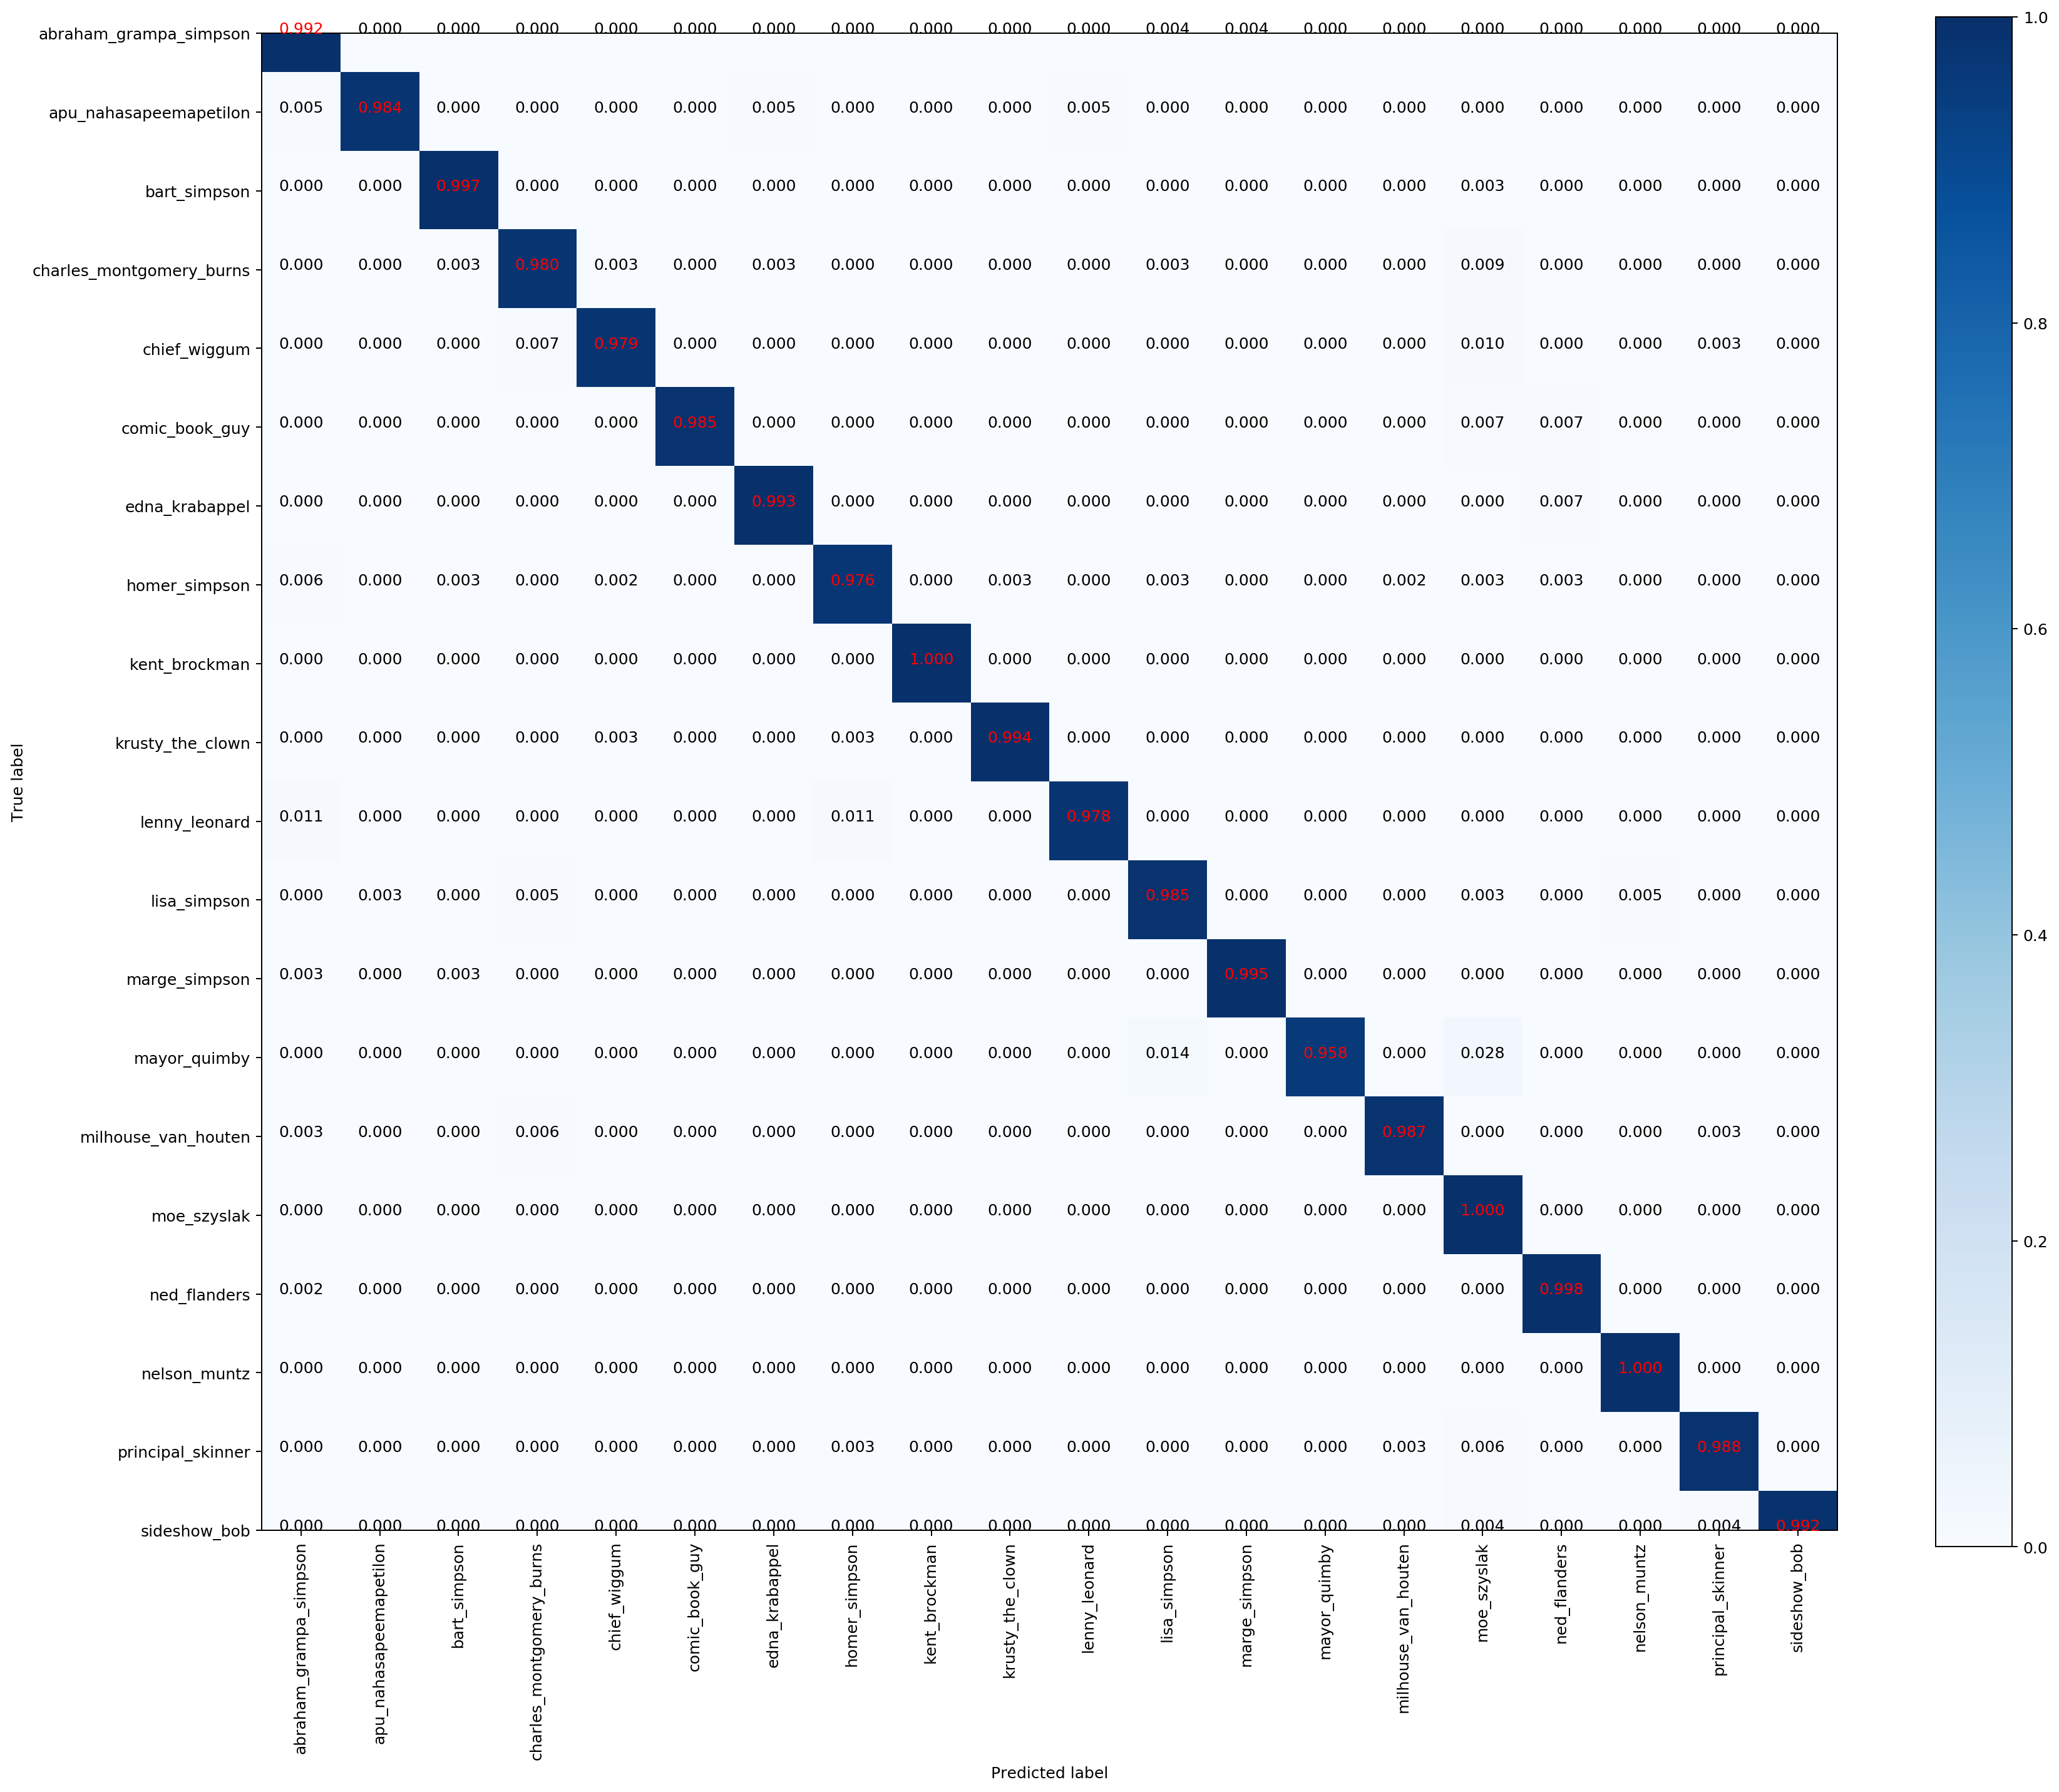

In [15]:
C = confusion_matrix(validGenerator.classes, valpredict)
plot_confusion_matrix(C, classes=target, normalize=True, cmap=plt.cm.Blues)

In [ ]:
sorce = os.path.join("RAW_DATA", dirname, file)
destination = os.path.join("noise", dirname, file)
predict = model.predict_generator(testGenerator)
predict2 = np.argmax(predict, axis=1)
for index, val in enumerate(predict2):
    if (
        val
        != trainGenerator.class_indices[testGenerator.filepaths[index].split("/")[-2]]
    ):
        sorce = os.path.join("RAW_DATA", testGenerator.filenames[index])
        destination = os.path.join("noise", testGenerator.filenames[index])
        copyfile(sorce, destination)
        os.remove(sorce)